In [1]:
import dlib
import os
import shutil
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
class LandmarksDataset_original:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.landmarks_files = [f for f in os.listdir(root_dir) if f.endswith('.pts')]
        self.detector = dlib.get_frontal_face_detector()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_name)

        landmarks_name = os.path.join(self.root_dir, self.landmarks_files[idx])
        landmarks = self._load_landmarks(landmarks_name)

        return image, landmarks

    def _load_landmarks(self, file_path):
        with open(file_path, 'r') as f:
            landmarks = []
            for line in f.readlines()[3:-1]:  # skip the first 3 and last lines
                x, y = map(float, line.split())
                landmarks.append([x, y])
            return np.array(landmarks)

In [11]:
dataset = LandmarksDataset_original('./landmarks_task/300W/test/')

In [12]:
detector = dlib.get_frontal_face_detector()

total_landmarks_inside_bbox = 0
total_landmarks = 0

for image, landmarks in tqdm(dataset):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = detector(rgb)

    # If no faces are detected, continue to the next image
    if len(faces) == 0:
        continue

    # Initialize variables to store information about the best face
    best_face = None
    max_landmarks_inside = 0

    # Iterate over all detected faces to find the one with the most landmarks inside
    for face in faces:
        landmarks_inside_bbox = 0
        for landmark in landmarks:
            x, y = landmark
            if face.left() <= x <= face.right() and face.top() <= y <= face.bottom():
                landmarks_inside_bbox += 1

        # Update the best face if the current face contains more landmarks
        if landmarks_inside_bbox > max_landmarks_inside:
            best_face = face
            max_landmarks_inside = landmarks_inside_bbox

    # If no landmarks are inside any detected face, continue to the next image
    if max_landmarks_inside == 0:
        continue

    # Calculate the percentage of landmarks inside the bounding box of the best face
    face_area = (best_face.right() - best_face.left()) * (best_face.bottom() - best_face.top())
    landmarks_inside_bbox_percentage = max_landmarks_inside / len(landmarks)

    # Update the total counts
    total_landmarks_inside_bbox += max_landmarks_inside
    total_landmarks += len(landmarks)

# Calculate the overall percentage of landmarks inside bounding boxes
bbox_percentage = total_landmarks_inside_bbox / total_landmarks
print("Percentage of landmarks inside bounding boxes:", bbox_percentage)

  0%|          | 0/281 [00:00<?, ?it/s]

Percentage of landmarks inside bounding boxes: 0.9052897278314311


In [37]:
def merge_datasets(folder1, folder2, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over images and landmarks in the first folder
    for file1 in os.listdir(folder1):
        if file1.endswith('.jpg'):
            basename = os.path.splitext(file1)[0]
            pts_file = os.path.join(folder1, basename + '.pts')
            if os.path.exists(pts_file) and count_landmarks(pts_file) == 68:
                shutil.copy(os.path.join(folder1, file1), os.path.join(output_folder, file1))
                shutil.copy(pts_file, os.path.join(output_folder, basename + '.pts'))

    # Iterate over images and landmarks in the second folder
    for file2 in os.listdir(folder2):
        if file2.endswith('.jpg'):
            basename = os.path.splitext(file2)[0]
            pts_file = os.path.join(folder2, basename + '.pts')
            if os.path.exists(pts_file) and count_landmarks(pts_file) == 68:
                shutil.copy(os.path.join(folder2, file2), os.path.join(output_folder, file2))
                shutil.copy(pts_file, os.path.join(output_folder, basename + '.pts'))

def count_landmarks(pts_file):
    with open(pts_file, 'r') as f:
        num_landmarks = sum(1 for line in f.readlines()[3:-1])
    return num_landmarks

In [40]:
folder1 = './landmarks_task/Menpo/train/'
folder2 = './landmarks_task/300W/train/'
output_folder = 'merged_landmarks_train'
merge_datasets(folder1, folder2, output_folder)

  0%|          | 0/16162 [00:00<?, ?it/s]

  0%|          | 0/6585 [00:00<?, ?it/s]

In [3]:
dataset = LandmarksDataset_original('./merged_landmarks_train/')

In [4]:
len(dataset)

8539

In [5]:
def detect_face_and_resize(image, landmarks):
    detector = dlib.get_frontal_face_detector()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        # If no face is detected, return None for both face and landmarks
        return None, None

    # Initialize variables to store the best face and the maximum number of landmarks inside a face
    best_face = None
    max_landmarks_inside = 0

    # Iterate over all detected faces to find the one with the most landmarks inside
    for face in faces:
        landmarks_inside = 0
        for x, y in landmarks:
            if face.left() <= x <= face.right() and face.top() <= y <= face.bottom():
                landmarks_inside += 1

        # Update the best face if the current face contains more landmarks
        if landmarks_inside > max_landmarks_inside:
            best_face = face
            max_landmarks_inside = landmarks_inside

    # If no landmarks are inside any detected face, return None for both face and landmarks
    if max_landmarks_inside == 0:
        return None, None

    landmarks_new = []

    for x, y in landmarks:
        if best_face.left() <= x <= best_face.right() and best_face.top() <= y <= best_face.bottom():
            x_new = (x - best_face.left()) / (best_face.right() - best_face.left())
            y_new = (y - best_face.top()) / (best_face.bottom() - best_face.top())
            landmarks_new.append([x_new, y_new])
        else:
            landmarks_new.append([-1, -1])

    # Crop and resize the best face
    try:
        face_image = image[best_face.top():best_face.bottom(), best_face.left():best_face.right()]
        face_image_resized = cv2.resize(face_image, (48, 48))
    except Exception as e:
        print(f"Error cropping/resizing face: {e}")
        return None, None

    return face_image_resized, np.array(landmarks_new)

def visualize_face_with_landmarks(image, landmarks):
    # Plot the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot the landmarks
    for landmark in landmarks:
        x, y = landmark
        if x != -1 and y != -1:
            plt.scatter(x * image.shape[1], y * image.shape[0], color='red', s=5)
    
    plt.axis('off')
    plt.show()

def visualize_face_with_original_landmarks(image, landmarks_original):
    # Plot the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot the landmarks
    for landmark in landmarks_original:
        x, y = landmark
        if x != -1 and y != -1:
            plt.scatter(x, y, color='red', s=5)
    
    plt.axis('off')
    plt.show()

def extract_landmarks(image, landmarks_normalized):
    # Load face detector and predictor
    detector = dlib.get_frontal_face_detector()
    
    # Convert normalized landmarks to original image coordinates
    def denormalize_landmarks(landmarks, face):
        face_width = face.right() - face.left()
        face_height = face.bottom() - face.top()
        denormalized_landmarks = []
        for x_norm, y_norm in landmarks:
            if x_norm == -1 and y_norm == -1:
                denormalized_landmarks.append([-1, -1])
            else:
                x_denorm = int((x_norm * face_width) + face.left())
                y_denorm = int((y_norm * face_height) + face.top())
                denormalized_landmarks.append([x_denorm, y_denorm])
        return denormalized_landmarks
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = detector(gray)
    
    if len(faces) == 0:
        return None
    
    # Assume only one face is detected
    face = faces[0]
    
    # Extract the face region
    face_image = image[face.top():face.bottom(), face.left():face.right()]
    
    # Resize the face image to (48, 48)
    face_image_resized = cv2.resize(face_image, (48, 48))
    
    # Convert landmarks from normalized to original coordinates
    landmarks_original = denormalize_landmarks(landmarks_normalized, face)
    
    return landmarks_original

In [6]:
sample = dataset[1]

In [7]:
face, landmarks = detect_face_and_resize(sample[0], sample[1])

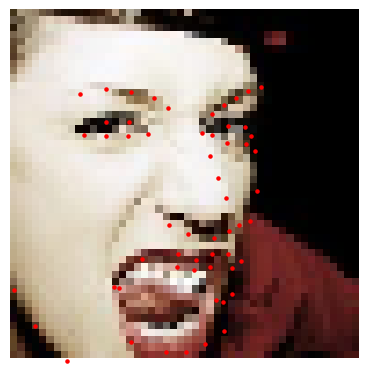

In [8]:
visualize_face_with_landmarks(face, landmarks)

In [9]:
original_landmarks = extract_landmarks(sample[0], landmarks)

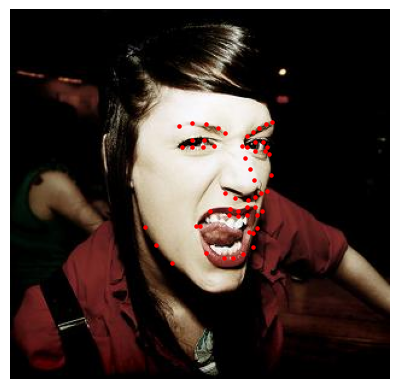

In [10]:
visualize_face_with_original_landmarks(sample[0], original_landmarks)

In [11]:
def create_dataset(dataset, output_folder, landmarks_file):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the landmarks file for writing
    with open(landmarks_file, 'w') as f:
        for i, sample in tqdm(enumerate(dataset)):
            face, landmarks = detect_face_and_resize(sample[0], sample[1])

            # If face is not detected, skip this sample
            if face is None:
                continue

            # Save cropped face to output folder
            face_filename = os.path.join(output_folder, f"face_{i}.jpg")
            cv2.imwrite(face_filename, face)

            # Write landmarks to landmarks file
            f.write(f"face_{i}.jpg")  # Write image filename
            for landmark in landmarks:
                x, y = landmark
                f.write(f" {x} {y}")
            f.write("\n")

In [12]:
dataset = LandmarksDataset_original('./merged_landmarks_train/')
output_folder = 'cropped_faces'
landmarks_file = 'landmarks.txt'
create_dataset(dataset, output_folder, landmarks_file)

0it [00:00, ?it/s]

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9

In [13]:
class LandmarksDataset(Dataset):
    def __init__(self, root_dir, landmarks_file, transform=None):
        self.root_dir = root_dir
        self.landmarks_file = landmarks_file
        self.transform = transform

        # Load landmarks from file
        self.landmarks = self._load_landmarks()

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        img_name, landmarks = self.landmarks[idx]

        # Load image
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        else:    
            image = transforms.ToTensor()(image)

        # Convert landmarks to tensor
        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        return image, landmarks

    def _load_landmarks(self):
        landmarks = []
        with open(self.landmarks_file, 'r') as f:
            for line in f:
                data = line.strip().split()
                img_name = data[0]
                landmarks_data = [float(coord) for coord in data[1:]]
                landmarks.append((img_name, landmarks_data))
        return landmarks

# Define color transformations and normalization
color_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Assuming RGB images
])

In [14]:
root_dir = 'cropped_faces'
landmarks_file = 'landmarks.txt'
dataset = LandmarksDataset(root_dir, landmarks_file, transform=color_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [15]:
for batch in dataloader:
    images, landmarks = batch
    break  # Only visualize the first batch

In [16]:
landmarks.shape

torch.Size([32, 136])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

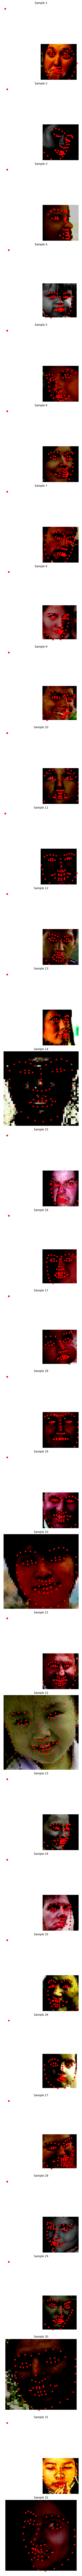

In [17]:
def visualize_batch(images, landmarks):
    num_samples = images.shape[0]
    fig, axes = plt.subplots(nrows=num_samples, ncols=1, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        landmarks_np = landmarks[i].numpy().reshape(-1, 2)  # Reshape landmarks to separate x and y coordinates
        landmarks_np = landmarks_np * 48 # de-normalization

        # Plot image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Plot landmarks
        axes[i].scatter(landmarks_np[:, 0], landmarks_np[:, 1], c='r', marker='o')
        axes[i].set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

# Example usage:
for batch in dataloader:
    images, landmarks = batch
    visualize_batch(images, landmarks)
    break  # Only visualize the first batch

In [120]:
folder1 = './landmarks_task/Menpo/test/'
folder2 = './landmarks_task/300W/test/'
output_folder = 'merged_landmarks_test'
merge_datasets(folder1, folder2, output_folder)

  0%|          | 0/1796 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

In [18]:
dataset = LandmarksDataset_original('./merged_landmarks_test/')
output_folder = 'cropped_faces_test'
landmarks_file = 'landmarks_test.txt'
create_dataset(dataset, output_folder, landmarks_file)

0it [00:00, ?it/s]

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error cropping/resizing face: OpenCV(4.9